In [2]:
import os
import pickle
import itertools
from datetime import datetime
from pprint import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text

from sklearn.metrics import mean_absolute_error

os.chdir("C:/2023_11-PTSFC")
import model_train as model_train
import data_prepro as data_prepro
import model_eval as model_eval

In [3]:
import importlib
importlib.reload(model_eval)

<module 'model_eval' from 'C:\\2023_11-PTSFC\\model_eval.py'>

### Import

In [22]:
# os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

In [5]:
# Read Pickle File of Scores
with open("2024-03-29_05-34-22 mstl/eval.pickle", "rb") as f:
    scores_dict = pickle.load(f)

# Read Pickle File of Fcasts
with open("2024-03-29_05-34-22 mstl/fcasts.pickle", "rb") as f:
    fcasts_dict = pickle.load(f)

### All Models Evaluation

In [6]:
input_dict = scores_dict
all_weekly_df_dict = {}

for week_key, weekly_scores in input_dict.items():

    weekly_scores_df_out = pd.DataFrame(index=list(input_dict[list(input_dict.keys())[0]].keys()),
                                    columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 
                                             'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975'])

    for key, model_scores in weekly_scores.items():

        weekly_scores_df_out.loc[key, 'avg_qscore'] = model_scores.values.mean()
        weekly_scores_df_out.loc[key, 'avg_qscore_0.025'] = model_scores.mean(axis=0).iloc[0]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.25'] = model_scores.mean(axis=0).iloc[1]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.5'] = model_scores.mean(axis=0).iloc[2]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.75'] = model_scores.mean(axis=0).iloc[3]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.975'] = model_scores.mean(axis=0).iloc[4]
        
    all_weekly_df_dict[week_key] = weekly_scores_df_out

# sum all dataframes in dict (all_weekly_df_dict) and take mean
weekly_scores_df_out = pd.concat(all_weekly_df_dict.values())
weekly_scores_df_out = weekly_scores_df_out.groupby(weekly_scores_df_out.index).mean()
weekly_scores_df_out = weekly_scores_df_out.sort_values(by='avg_qscore', ascending=True)
# highlight min value in each col
display(weekly_scores_df_out.style.highlight_min(color = 'yellow', axis = 0))

,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975
mstl_0.5,0.752816,0.187625,1.035197,1.311123,1.024416,0.205716
mstl_0.25,0.763535,0.207902,1.076758,1.315045,1.009274,0.208693
mstl_4,0.793431,0.236671,1.077169,1.339435,1.086914,0.226968
mstl_3,0.794864,0.237304,1.078629,1.338937,1.090133,0.229319
mstl_1.5,0.798860,0.238826,1.083723,1.338937,1.098139,0.234672
mstl_2,0.799886,0.239668,1.084982,1.338937,1.100006,0.235837
mstl_1,0.800466,0.241344,1.084623,1.322330,1.110011,0.244023


### Extra Horizon Analysis from Fcasts

In [7]:
def eval_all_ensembles_detailed(ens_size, all_models, fcasts_dict_all):

    # Generate all possible combinations
    # ens_size = 1
    combis = list(itertools.combinations(all_models, ens_size))
    # filter out all ensembles with repeating models
    combis = [combi for combi in combis if len(set(combi)) == ens_size]
    print(len(combis))

    # Define the start and end dates
    start_date = pd.Timestamp('2023-11-15')
    end_date = pd.Timestamp('2024-02-14')

    # Generate a list of weekly dates in UTC
    fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tz_localize('CET').strftime('%Y-%m-%d').tolist()

    res_dict = {}

    # Iterate over the forecast dates
    for fcast_idx, fcast_date in enumerate(fcast_dates_cet):

        # print('= '*30)
        print(f"Forecasting for week starting from {fcast_date} ...")

        # = = = = = = = = = = = = = 
        # generate prediction timestamps based on t0 = following thursday 00:00
        # = = = = = = = = = = = = = 

        # Calculate the Thursday and Wednesday of the week
        t_wednesday = pd.Timestamp(fcast_date).replace(hour=0, minute=0, second=0, microsecond=0).tz_localize('CET')
        subm_timestamps = [(t_wednesday + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
        # print(f"Submission timestamps = {subm_timestamps[0]} to {subm_timestamps[-1]}")

        weekly_fcasts = fcasts_dict_all[fcast_date]

        # = = = = = = = = = = = = = 
        # Evaluation based on submission timestamps
        # = = = = = = = = = = = = = 

        # get actual values at every submission timestamp
        df_energy_eval = df_energy.loc[df_energy['timestamp_CET'].isin(subm_timestamps)].copy()

        weekly_model_scores_dict = {}

        for combi_idx, combi in enumerate(combis):

            # calculate ensemble between the preds of the models in the current combination
            pred_list = [weekly_fcasts[model] for model in combi]
            new_name = f"ens | {', '.join(combi)}" if ens_size > 1 else combi[0]

            # Ignore timestamp_CET column and take the average of the quantiles
            pred_vals_list = [pred.iloc[:, 1:].copy() for pred in pred_list]

            # Take the average of the quantiles across all models in the ensemble
            ens_pred_df = pred_list[0].copy()
            ens_pred_df.iloc[:, 1:] = sum(pred_vals_list) / len(pred_vals_list)
            df_scores = model_eval.eval_fcast_qscore(ens_pred_df, df_energy_eval, subm_timestamps, quantiles)

            subm_df = ens_pred_df.loc[ens_pred_df['timestamp_CET'].isin(subm_timestamps)]
            # Save the last row of the scores dataframe to final output
            df_scores['coverage_50'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 2], subm_df.iloc[:, 4])
            df_scores['coverage_95'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 1], subm_df.iloc[:, 5])
            df_scores['mae_q0.5'] = np.abs(subm_df['q 0.500'] - df_energy_eval['gesamt'])

            weekly_model_scores_dict[new_name] = df_scores

        res_dict[fcast_date] = weekly_model_scores_dict

    return res_dict


In [8]:
all_models = list(fcasts_dict['2023-11-15'].keys())
res_dict_detailed = eval_all_ensembles_detailed(1, all_models, fcasts_dict)

# res_df_1 = pd.concat(res_dict_1.values())
# res_df_1 = res_df_1.groupby(res_df_1.index).mean() # .sort_values(by='avg_qscore', ascending=True)
# # export to csv
# # res_df_1.to_csv("2024_03_28 single model scores.csv")
# display(res_df_1.style.highlight_min(color = 'yellow', axis=0))

7
Forecasting for week starting from 2023-11-15 ...
Forecasting for week starting from 2023-11-22 ...
Forecasting for week starting from 2023-11-29 ...
Forecasting for week starting from 2023-12-06 ...
Forecasting for week starting from 2023-12-13 ...
Forecasting for week starting from 2023-12-20 ...
Forecasting for week starting from 2023-12-27 ...
Forecasting for week starting from 2024-01-03 ...
Forecasting for week starting from 2024-01-10 ...
Forecasting for week starting from 2024-01-17 ...
Forecasting for week starting from 2024-01-24 ...
Forecasting for week starting from 2024-01-31 ...
Forecasting for week starting from 2024-02-07 ...
Forecasting for week starting from 2024-02-14 ...


In [18]:
input_dict = res_dict_detailed.copy()
all_models = input_dict['2023-11-15'].keys()

model_scores_entire_period_dict = {}
model_avg_scores_entire_period_dict = {}

for model in all_models:
    scores_df_list = [week_dict[model] for week_dict in input_dict.values()]
    model_scores_entire_period_dict[model] = pd.concat(scores_df_list)

    # replace index of each df in scores_df_list with integers 0 to length
    scores_df_list = [df.reset_index(drop=True) for df in scores_df_list]
    # remove cols not containing 'q-score'
    scores_df_list = [df.loc[:, df.columns.str.contains('q-score')] for df in scores_df_list]
    temp_df = pd.concat(scores_df_list).groupby(level=0).mean()
    model_avg_scores_entire_period_dict[model] = temp_df

#### plot

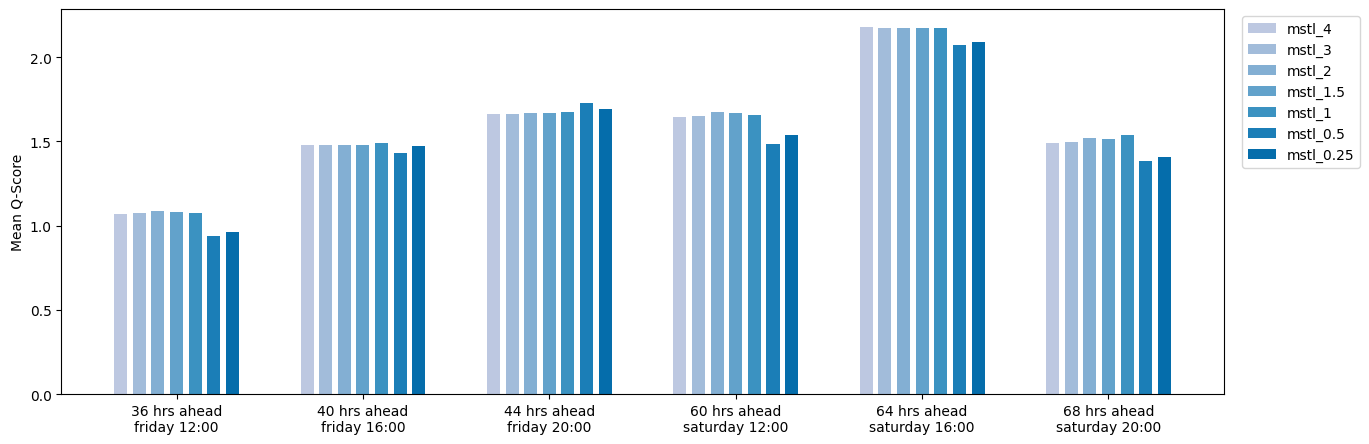

In [58]:
plt.figure(figsize=(15, 5))

# mark fcast dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

# Define colormap
# colormap = plt.cm.get_cmap('Blues', len(all_models))
# cmaps = ['Blues', 'GnBu', 'PuBu', 'Purples', 'Greens']
colormap = mpl.colormaps.get_cmap('PuBu')

for i, model in enumerate(all_models):
    model_df = model_avg_scores_entire_period_dict[model].mean(axis=1)
    color = colormap((i+4) / (len(all_models)+6))  
    plt.bar(np.arange(len(fcast_hor)) + i*0.1 + 0.3, model_df, width=0.07, label=model, color=color)

# custom xlabels
xlabels = [f'{hor} hrs ahead' for hor in fcast_hor]
labels_add = ['friday 12:00', 'friday 16:00', 'friday 20:00',
              'saturday 12:00', 'saturday 16:00', 'saturday 20:00']
# add labels_add behind xlabels and put \n in between
xlabels = [f'{x}\n{labels_add[i]}' for i, x in enumerate(xlabels)]
plt.xticks(ticks=np.arange(len(fcast_hor)) + 0.2 * (len(all_models) - 1) / 2, labels=xlabels)

plt.ylabel('Mean Q-Score')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

In [59]:
# plt.figure(figsize=(15, 5))

# # mark fcast dates
# start_date = pd.Timestamp('2023-11-15')
# end_date = pd.Timestamp('2024-02-14')
# fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

# for model in all_models:
#     model_df = model_avg_scores_entire_period_dict[model].mean(axis=1)
#     plt.plot(model_df.index, model_df, label=model)

# # custom xlabels
# xlabels = [f'{hor} hrs ahead' for hor in fcast_hor]
# labels_add = ['friday 12:00', 'friday 16:00', 'friday 20:00',
#               'saturday 12:00', 'saturday 16:00', 'saturday 20:00']

# # add labels_add behind xlabels and put \n in between
# xlabels = [f'{x}\n{labels_add[i]}' for i, x in enumerate(xlabels)]
# plt.xticks(ticks=np.arange(len(fcast_hor)), labels=xlabels)

# plt.ylabel('Mean Q-Score')
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.show()

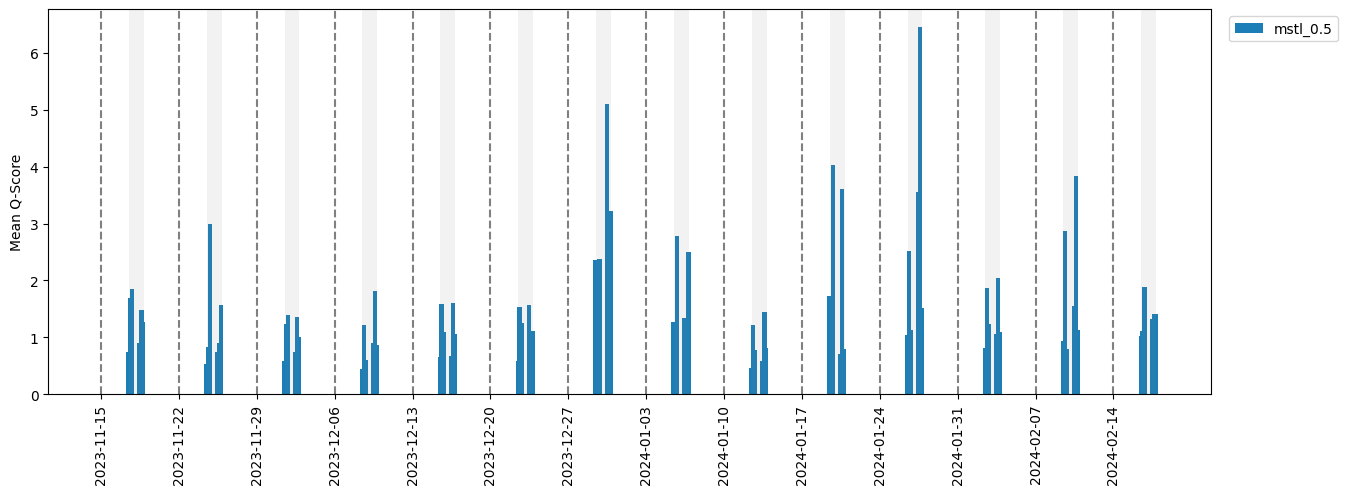

In [102]:
plt.figure(figsize=(15, 5))

# mark fcast dates
start_date = pd.Timestamp('2023-11-15')
end_date = pd.Timestamp('2024-02-14')
fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

# Define colormap
colormap = mpl.colormaps.get_cmap('PuBu')

model = 'mstl_0.5'
model_df = model_scores_entire_period_dict[model].iloc[:,:5].mean(axis=1) # subset qscores only
color = colormap((5+4) / (len(all_models)+6))  
plt.bar(model_df.index, model_df, label=model, color=color, width=0.4)

# mark fcast dates
for fcast_date in fcast_dates_cet:
    plt.axvline(fcast_date, color='grey', linestyle='--')
    subm_timestamps = [(fcast_date + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
    # highlight area from first subm_timestamp to last subm_timestamp
    plt.axvspan(subm_timestamps[0], subm_timestamps[-1], alpha=0.1, lw=0, color='grey')

# custom x ticks as fcast_dates_cet
fcast_dates_cet_str = [date.strftime('%Y-%m-%d') for date in fcast_dates_cet]
plt.xticks(ticks=fcast_dates_cet, labels=fcast_dates_cet_str, rotation=90)

plt.ylabel('Mean Q-Score')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

In [103]:
# plt.figure(figsize=(15, 5))

# # mark fcast dates
# start_date = pd.Timestamp('2023-11-15')
# end_date = pd.Timestamp('2024-02-14')
# fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tolist()

# for fcast_date in fcast_dates_cet:

#     plt.axvline(fcast_date, color='grey', linestyle='--')
#     subm_timestamps = [(fcast_date + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
#     # highlight are from first subm_timestamp to last subm_timestamp
#     plt.axvspan(subm_timestamps[0], subm_timestamps[-1], alpha=0.1, lw=0, color='grey')
    
#     # get part of model_df that is within the submission timestamps
#     model_df = model_scores_entire_period_dict['mstl_0.5'].iloc[:,:5].mean(axis=1)
#     model_df.index = [x.replace(tzinfo=None) for x in model_df.index]
#     model_df = model_df.loc[model_df.index.isin(subm_timestamps)]
#     # plt.scatter(model_df.index, model_df, label=model, s=5, marker='x')
#     plt.plot(model_df.index, model_df, label=model, c='blue')

# # rotate x labels 90 degrees
# plt.ylabel('Mean Q-Score')
# # set custom x ticks as fcast_dates_cet
# fcast_dates_cet_str = [date.strftime('%Y-%m-%d') for date in fcast_dates_cet]
# plt.xticks(ticks=fcast_dates_cet, labels=fcast_dates_cet_str, rotation=90)
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.show()